# Self-Driving Car Engineer Nanodegree


## Project: Advance Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Calibrating camera path: ./camera_cal/calibration*.jpg
Camera Calibrated


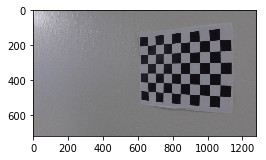

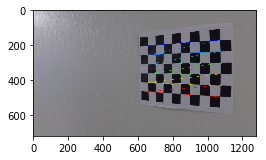

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

out_dir='./output_images/'
mtx_dist_file = 'camera_dist_pickle.p'
def camera_calibrate(path):
    print("Calibrating camera path: " + path)
    images = glob.glob(path)#mpimg.imread(path)
    show_img = True
    for img_index, file_name in enumerate(images):
        img = mpimg.imread(file_name)
        obj_points = [] #3D points in real world space
        img_points = [] #2D points in image
        
        obj_point = np.zeros((6*9, 3), np.float32)
        obj_point[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            if show_img:
                plt.figure(figsize=(4,4))
                plt.imshow(img)
            img_points.append(corners)
            obj_points.append(obj_point)

            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            write_name = out_dir + 'image_point_' + str(img_index) + '.jpg'
            cv2.imwrite(write_name, img)
            if show_img:
                plt.figure(figsize=(4,4))
                plt.imshow(img)
                show_img = False
    print("Camera Calibrated")
    return obj_points, img_points

points = camera_calibrate('./camera_cal/calibration*.jpg')

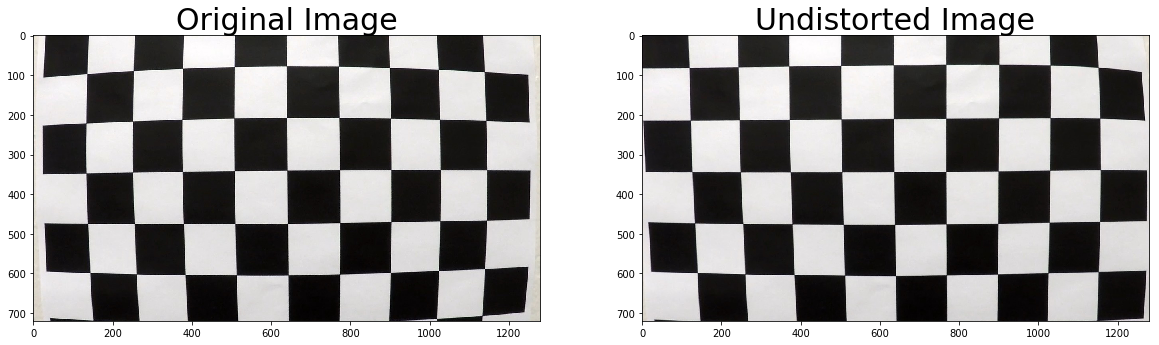

In [2]:
import pickle
def mtx_dist_get(path, obj_points, img_points):
    img = mpimg.imread(path)
    
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size = (img.shape[0], img.shape[1])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open(mtx_dist_file, "wb" ) )
    return img, undistorted_img

obj_points, img_points = points
original_image, undistorted_img = mtx_dist_get('./camera_cal/calibration1.jpg', obj_points, img_points)
write_name = out_dir + 'undistorted_' + 'calibration_1' + '.jpg'
cv2.imwrite(write_name, undistorted_img)

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))
ax1.imshow(original_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)

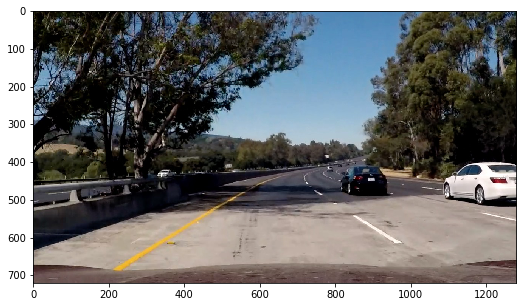

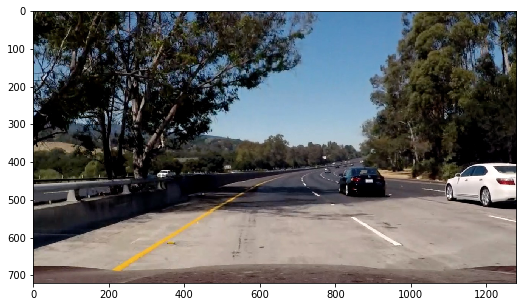

In [3]:
def mtx_dist_load():
    dist_pickle = pickle.load(open(mtx_dist_file, "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    return mtx, dist

def images_undistort(path, mtx, dist):
    images_path = glob.glob(path)
    original_images = []
    undistorted_images = []
    for index, file_name in enumerate(images_path):
        img = mpimg.imread(file_name)
        original_images.append(img)
        undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
        undistorted_images.append(undistorted_img)
        write_name = out_dir + 'test_image_undistorted_' + str(index) + '.jpg'
        cv2.imwrite(write_name, undistorted_img)
    return original_images, undistorted_images

mtx, dist = mtx_dist_load()
original_images, undistorted_images = images_undistort('test_images/*.jpg', mtx, dist)
plt.figure(figsize=(10, 5))
plt.imshow(original_images[0])
plt.figure(figsize=(10, 5))
plt.imshow(undistorted_images[0])

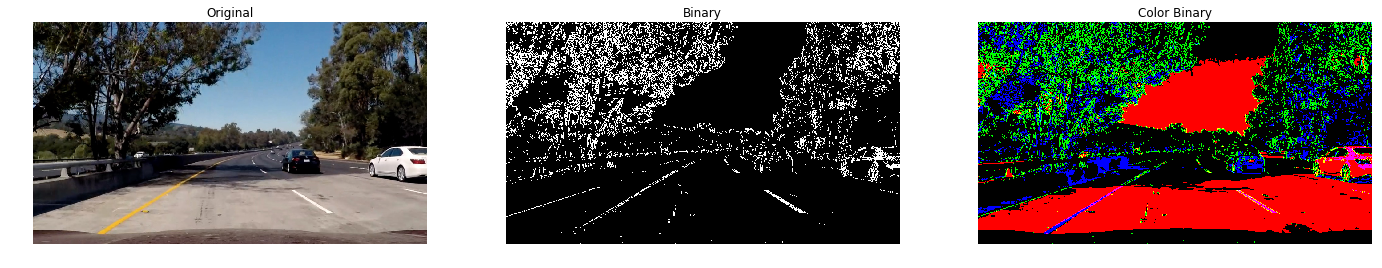

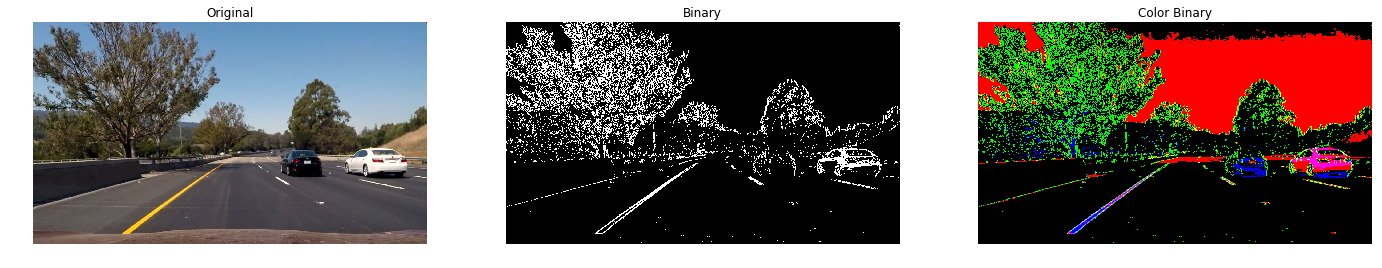

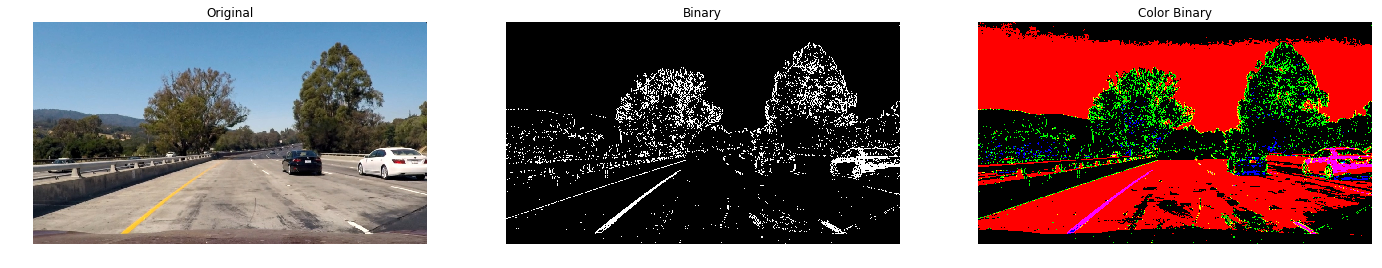

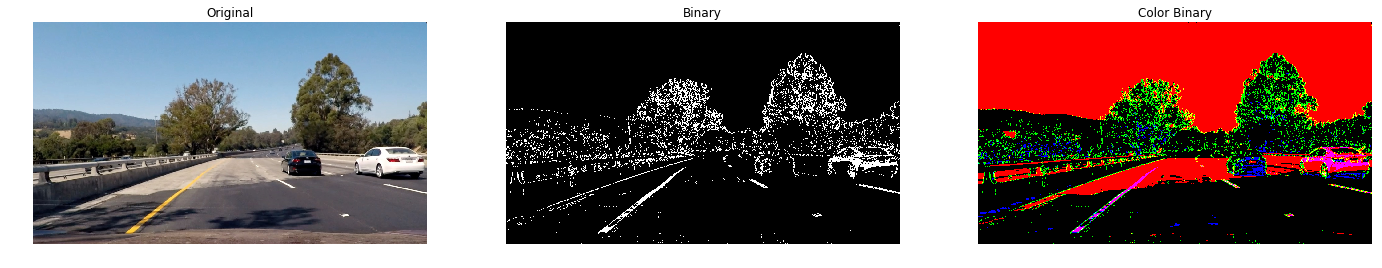

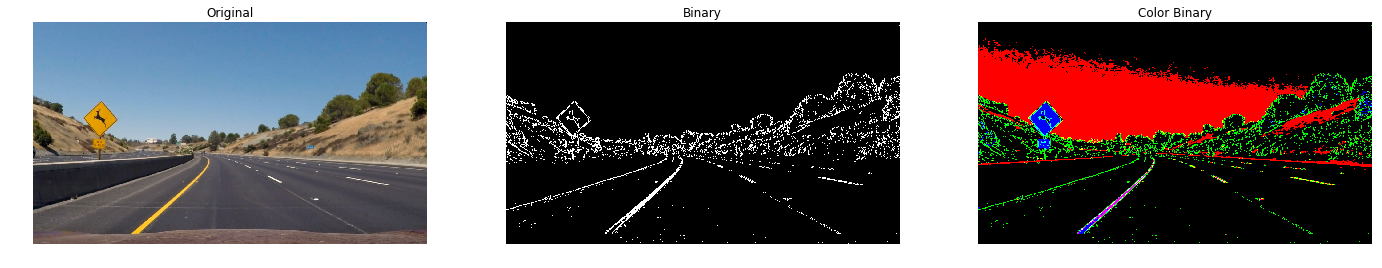

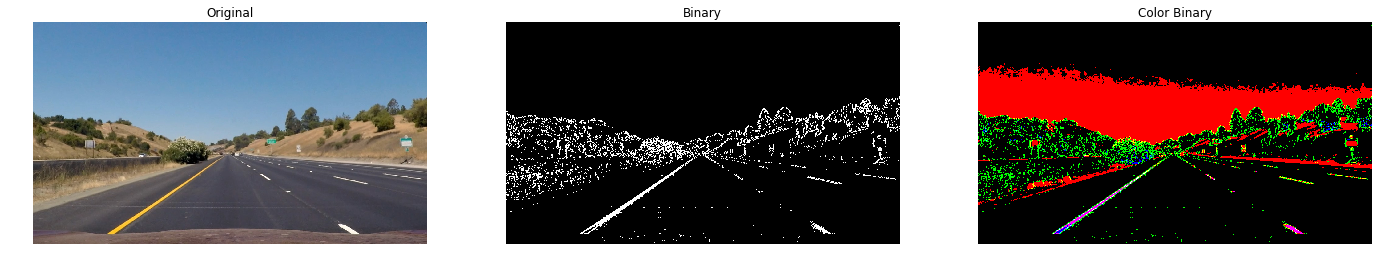

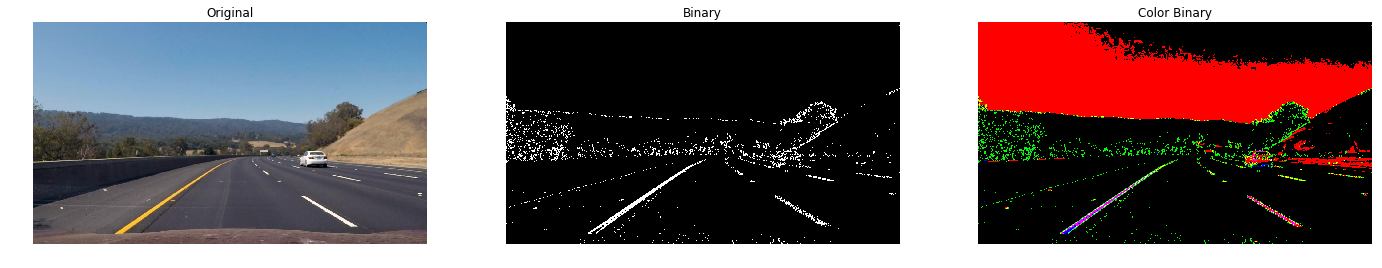

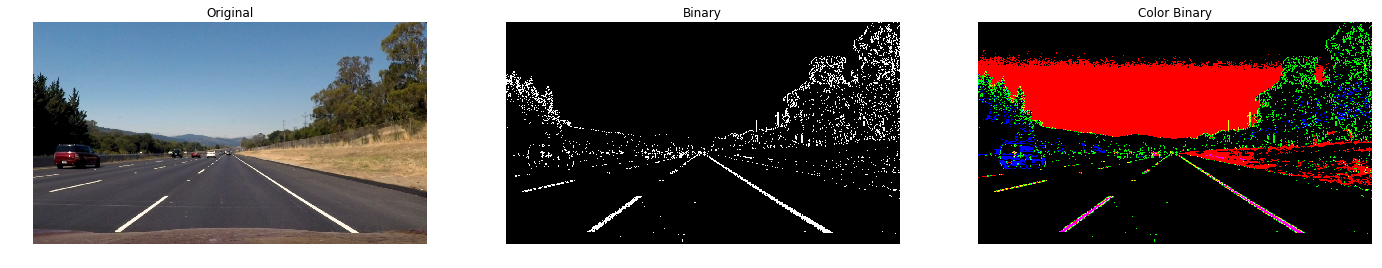

In [4]:


def color_thresh_apply(img, s_thresh=(170, 255), sx_thresh=(20, 100), l_thresh=(150,255)):
    undistorted_images = np.copy(img)
    # Convert to HLS color space and separate the H channel
    hls = cv2.cvtColor(undistorted_images, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8') * 255
    
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = np.dstack((binary,binary,binary)).astype('uint8') * 255
    return binary, color_binary

binary_images = []
color_binary_images = []
for img_index, undistorted_img in enumerate(undistorted_images):
    binary, color_binary = color_thresh_apply(undistorted_img)
    
    binary_images.append(binary)
    color_binary_images.append(color_binary)
    
    fig, axs = plt.subplots(1, 3, figsize=(24, 9))
    axs = axs.ravel()
    axs[0].imshow(undistorted_img)
    axs[0].axis('off')
    axs[0].set_title("Original")
    
    axs[1].imshow(binary)
    axs[1].axis('off')
    axs[1].set_title("Binary")
    
    axs[2].imshow(color_binary)
    axs[2].axis('off')
    axs[2].set_title("Color Binary")

Corners
[[  190.   720.]
 [  570.   468.]
 [  705.   468.]
 [ 1130.   720.]]


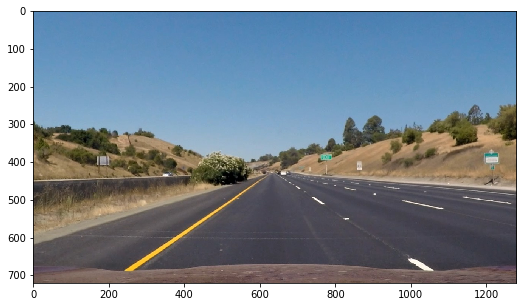

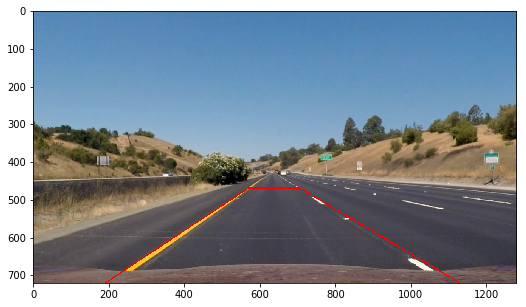

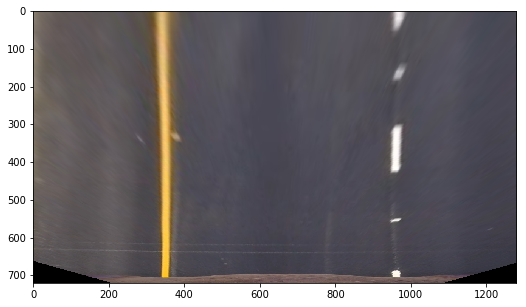

In [6]:
imshape = (undistorted_images[len(undistorted_images) - 3]).shape
corners = np.array([(190,imshape[0]),((imshape[1]/2) - 70, imshape[0] * 0.65),
                          ((imshape[1]/2) + 65, imshape[0] * 0.65),
                          (imshape[1] - 150, imshape[0])], dtype=np.float32)

def image_warp(img):
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])

    offset=[150,0]
    img_size = (img.shape[1], img.shape[0]) 

    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])
    src = corners
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M

straight_image = np.copy(undistorted_images[len(undistorted_images) - 3])
plt.figure(figsize=(10, 5))
plt.imshow(straight_image)
print("Corners")
print(corners)
cv2.line(straight_image, tuple(corners[0]), tuple(corners[1]), color=[255,0,0], thickness=2)
cv2.line(straight_image, tuple(corners[1]), tuple(corners[2]), color=[255,0,0], thickness=2)
cv2.line(straight_image, tuple(corners[2]), tuple(corners[3]), color=[255,0,0], thickness=2)
cv2.line(straight_image, tuple(corners[3]), tuple(corners[0]), color=[255,0,0], thickness=2)

plt.figure(figsize=(10, 5))
plt.imshow(straight_image)

warped_img, M = image_warp(undistorted_images[len(undistorted_images) - 3])
plt.figure(figsize=(10, 5))
plt.imshow(warped_img)

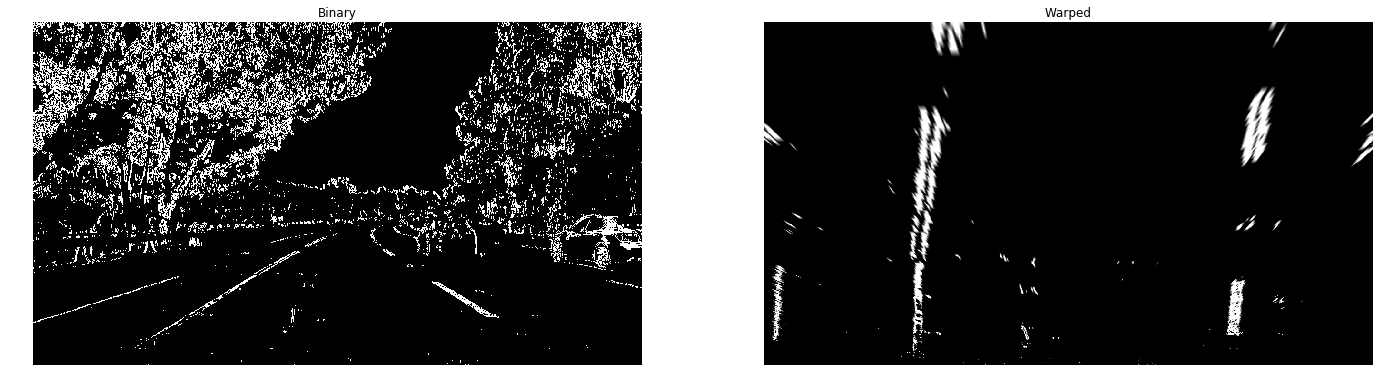

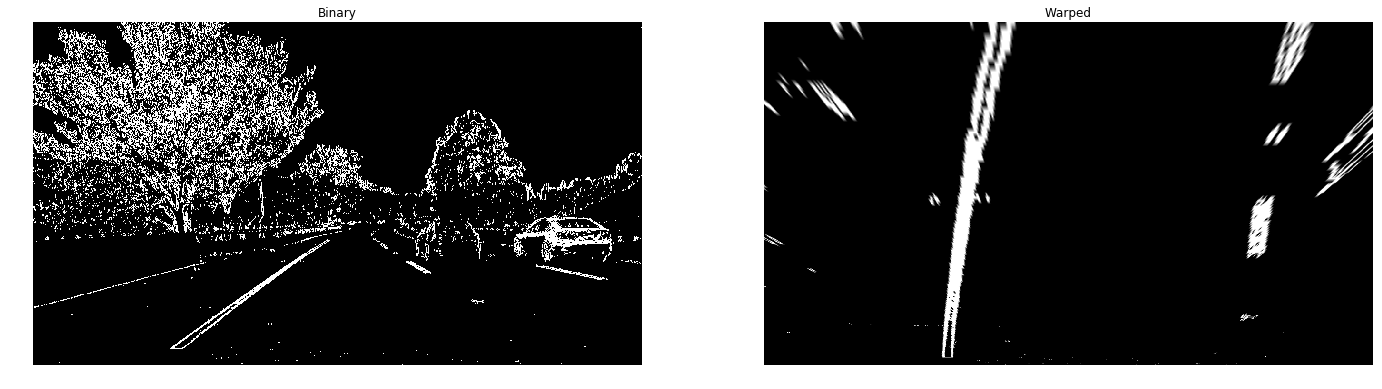

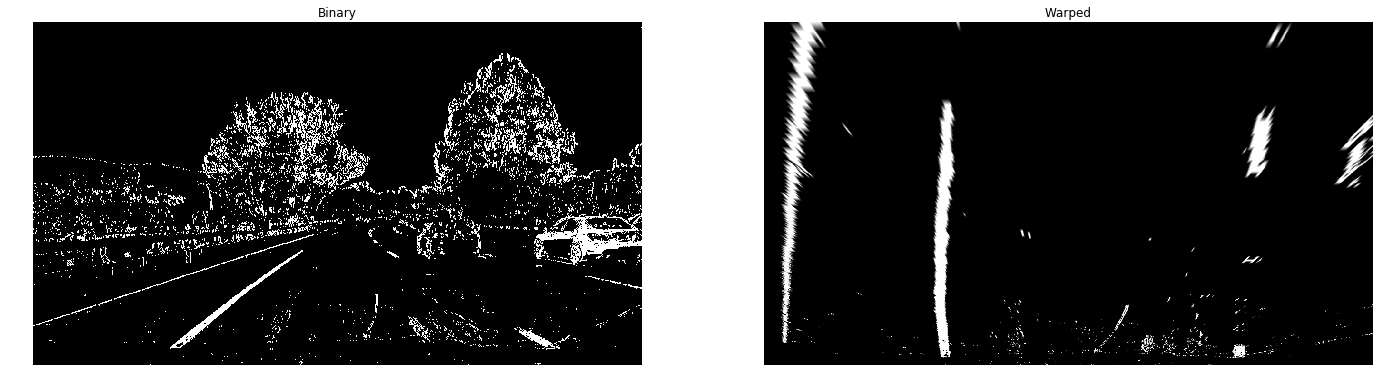

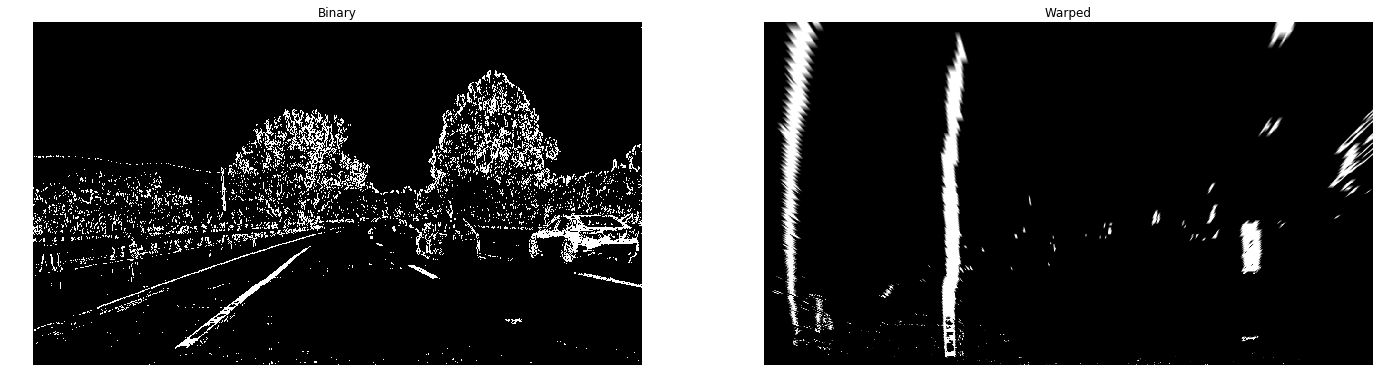

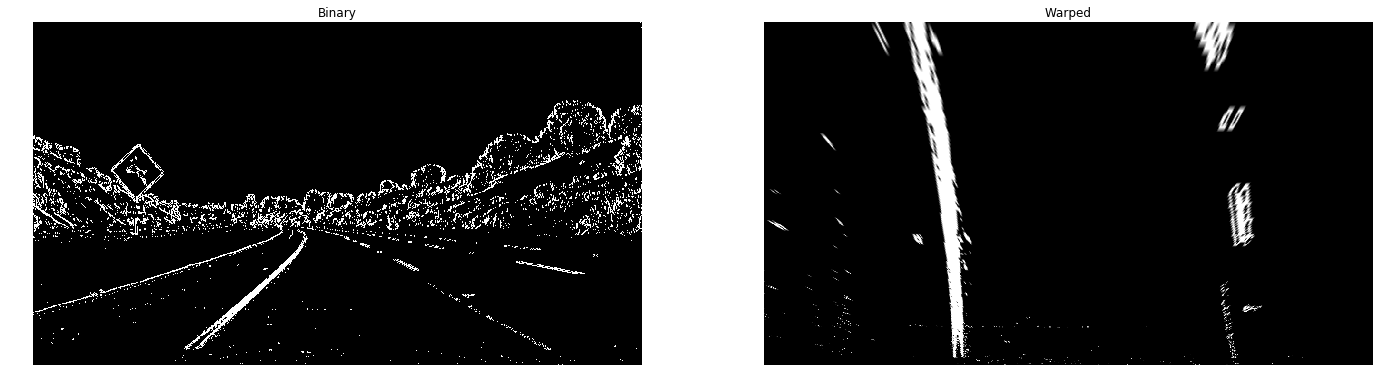

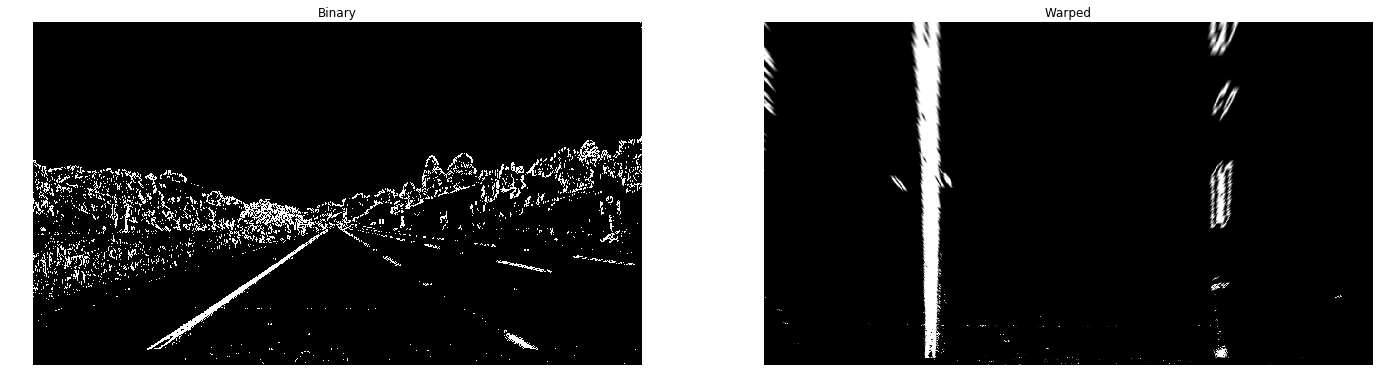

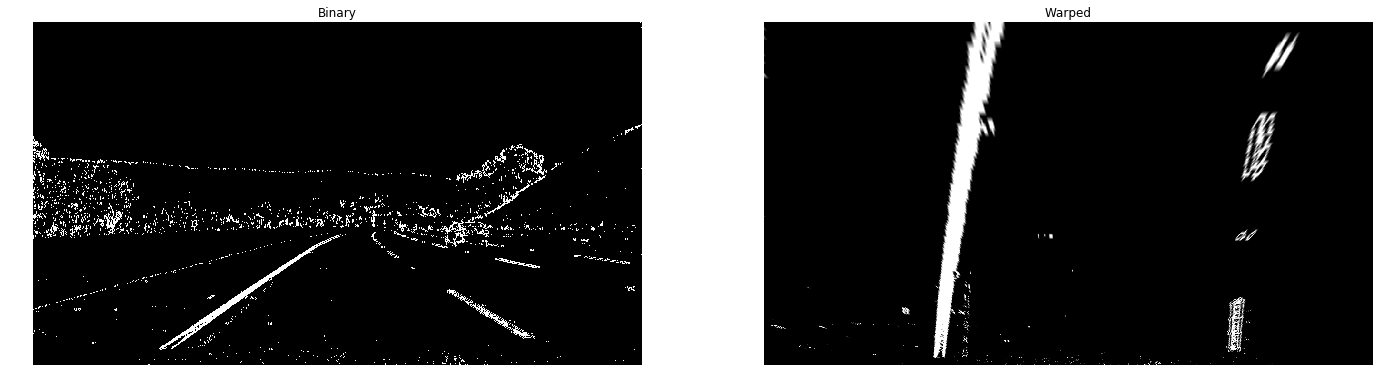

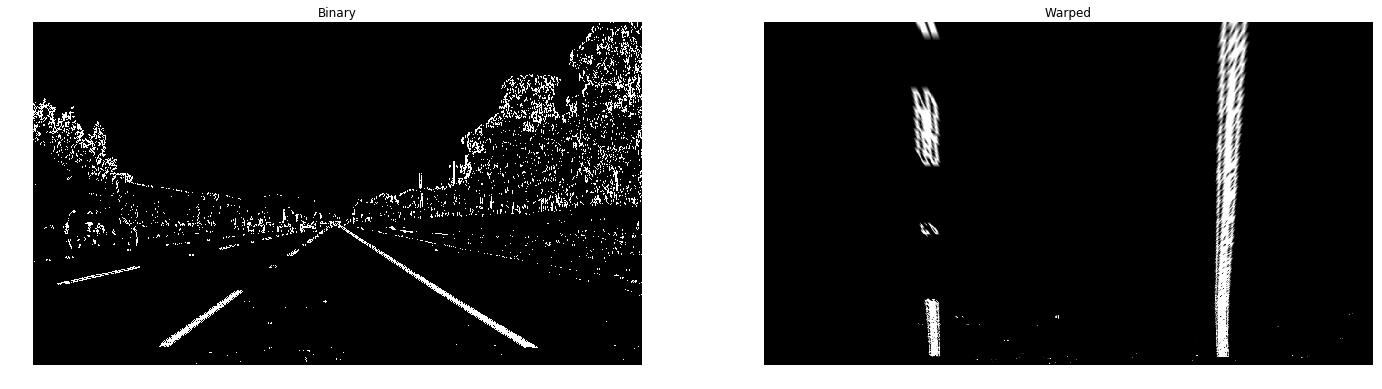

In [7]:
warped_images = []
for binary_image in binary_images:
    warped_image, M = image_warp(binary_image)
    
    warped_images.append(warped_image)
    
    fig, axs = plt.subplots(1, 2, figsize=(24, 9))
    axs = axs.ravel()
    axs[0].imshow(binary_image)
    axs[0].axis('off')
    axs[0].set_title("Binary")
    
    axs[1].imshow(warped_image)
    axs[1].axis('off')
    axs[1].set_title("Warped")

In [8]:
#vertices = np.array([[(60,imshape[0]),((imshape[1]/2) - 25, imshape[0] * 0.6),
#                          ((imshape[1]/2) + 25, imshape[0] * 0.6),
#                          (imshape[1] - 60, imshape[0])]], dtype=np.int32)


def region_of_interest_mask(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img) 
    shape = img.shape
    
    vertices_1 = np.array([[(1000,0),(shape[1]-100,0),(shape[1],0),(0.84*shape[1],shape[0]),
                      (shape[1]*0.16,shape[0]), (0,0)]],dtype=np.int32)
    
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices_1, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    vertices_1 = vertices_1[0]
    cv2.line(masked_image, tuple(vertices_1[0]), tuple(vertices_1[1]), color=[255,0,0], thickness=2)
    cv2.line(masked_image, tuple(vertices_1[1]), tuple(vertices_1[2]), color=[255,0,0], thickness=2)
    cv2.line(masked_image, tuple(vertices_1[2]), tuple(vertices_1[3]), color=[255,0,0], thickness=2)
    cv2.line(masked_image, tuple(vertices_1[3]), tuple(vertices_1[4]), color=[255,0,0], thickness=2)
    cv2.line(masked_image, tuple(vertices_1[4]), tuple(vertices_1[5]), color=[255,0,0], thickness=2)
    cv2.line(masked_image, tuple(vertices_1[5]), tuple(vertices_1[0]), color=[255,0,0], thickness=2)
        
    
    return masked_image

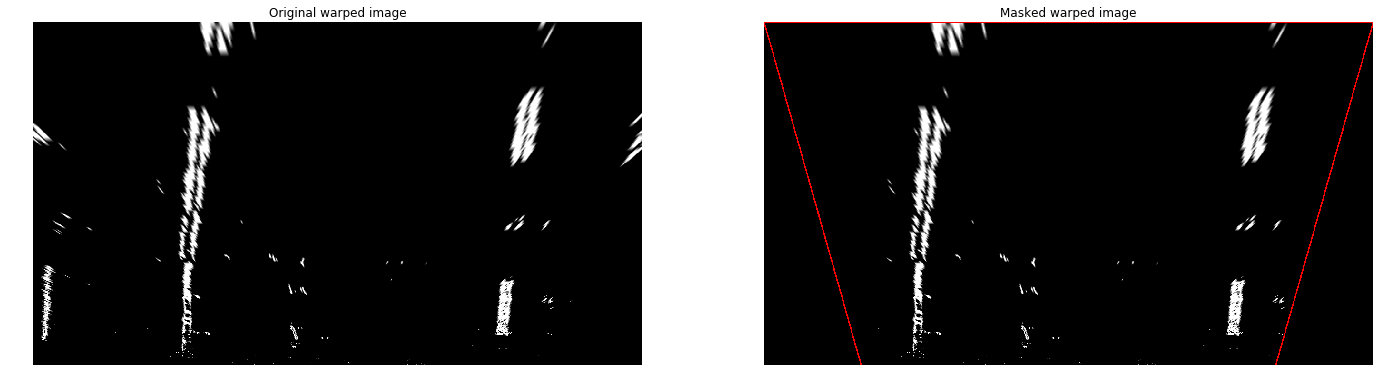

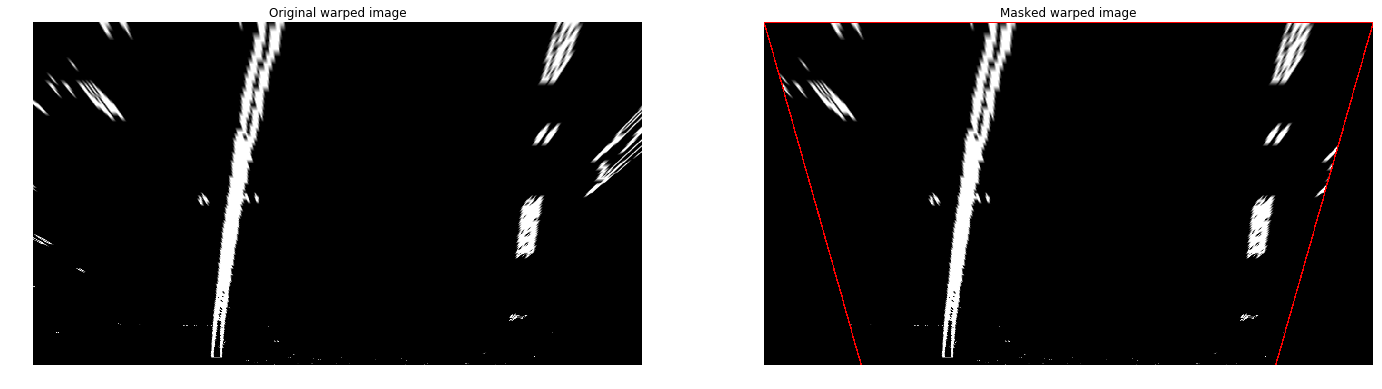

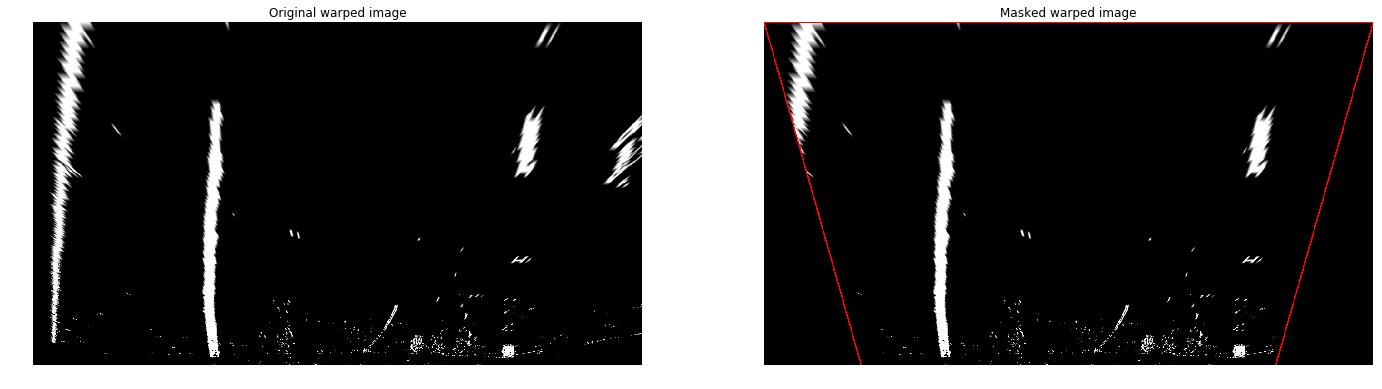

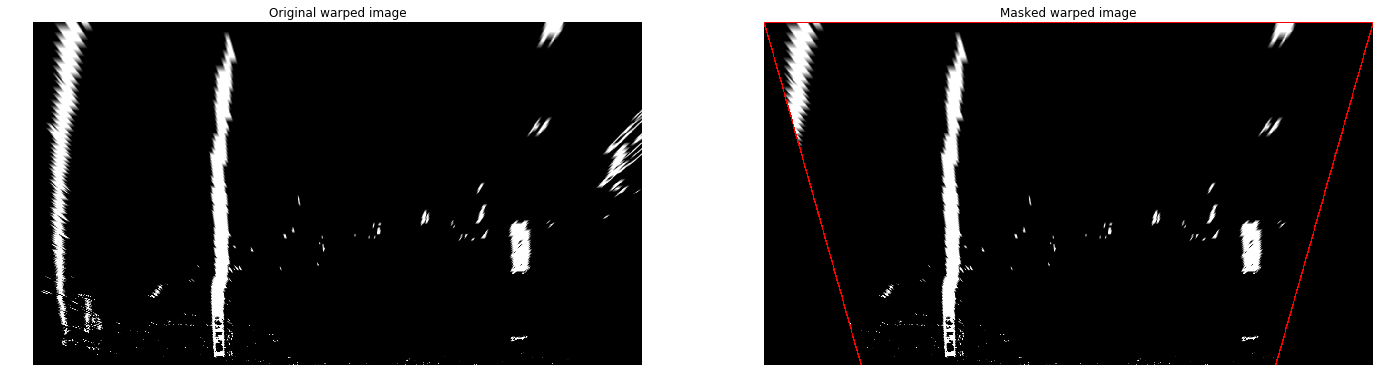

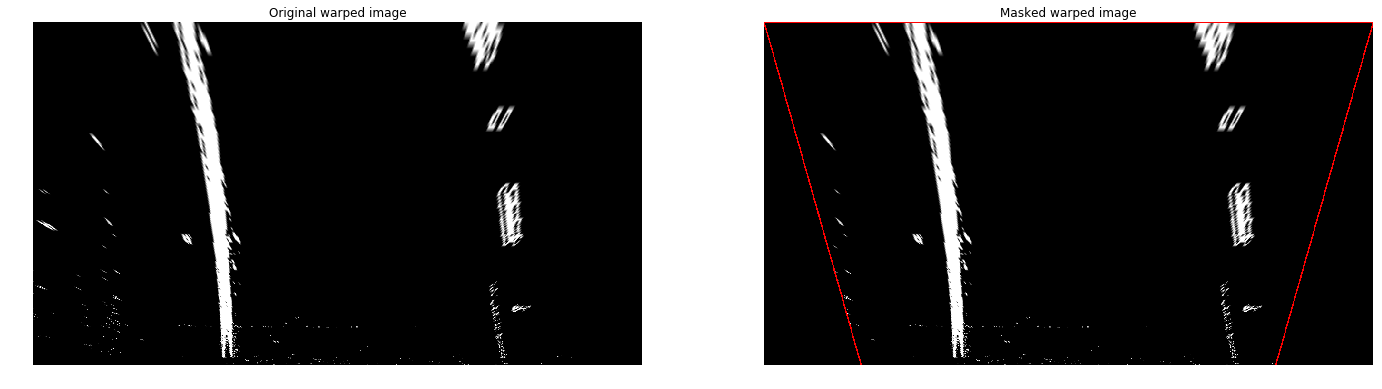

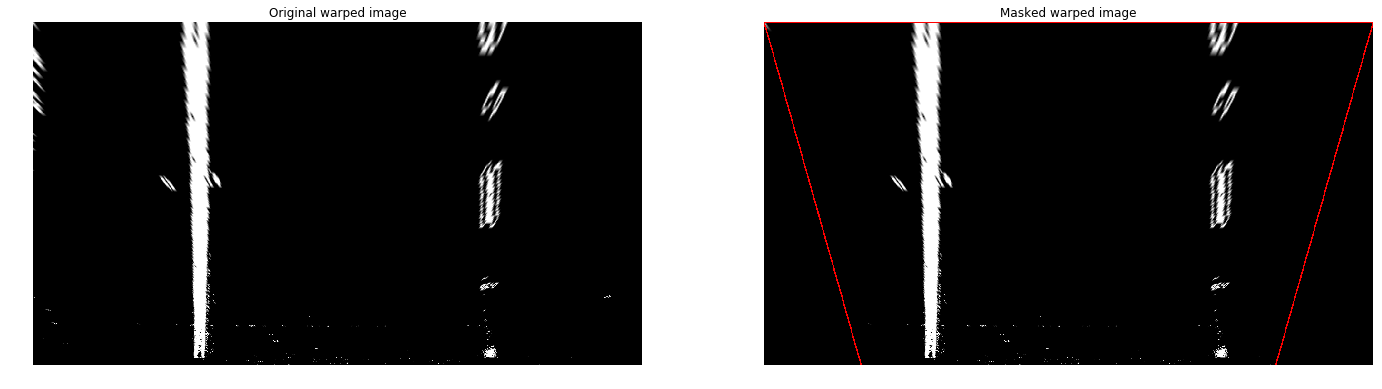

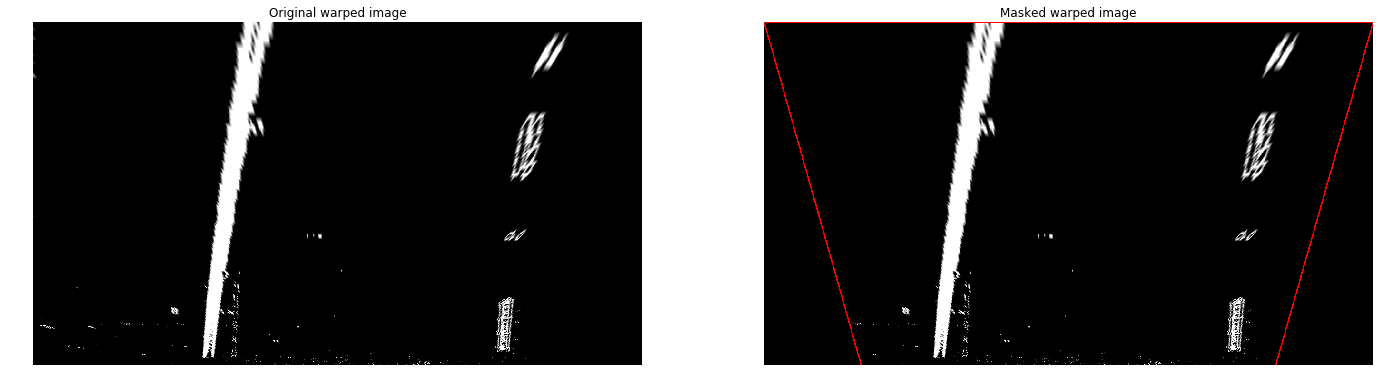

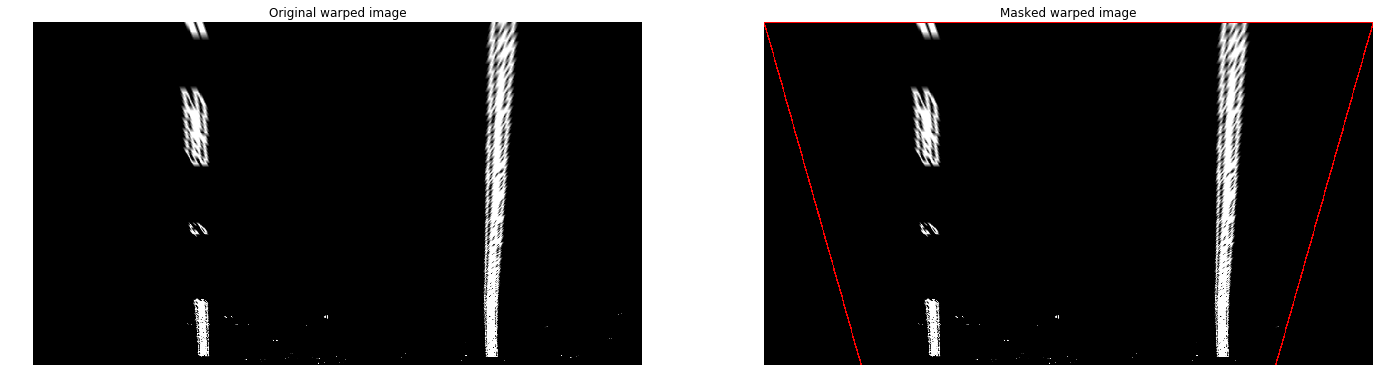

In [9]:

warped_images_masked = []
for warped_image in warped_images:
    masked_image = region_of_interest_mask(warped_image)
    
    warped_images_masked.append(masked_image)
    
    fig, axs = plt.subplots(1, 2, figsize=(24, 9))
    axs = axs.ravel()
    axs[0].imshow(warped_image)
    axs[0].axis('off')
    axs[0].set_title("Original warped image")
    
    axs[1].imshow(masked_image)
    axs[1].axis('off')
    axs[1].set_title("Masked warped image")